In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Overview

TensorFlow is a software library for numerical computation using data flow graphs, a programming paradigm that models a program as a directed graph of the data flowing between operations. TensorFlow's flexible architecture allows you to deploy computation to one or more CPUs or GPUs in a desktop, server, or mobile device with a single API. TensorFlow was originally developed by researchers and engineers working on the Google Brain Team within Google's Machine Intelligence research organization for the purposes of conducting machine learning and deep neural networks research, but the system is general enough to be applicable in a wide variety of other domains as well. TensorFlow was open sourced under the Apache 2.0 License in November 2015. 

TensorFlow provides multiple APIs. The lowest level API --TensorFlow Core-- provides you with complete programming control. We recommend TensorFlow Core for machine learning researchers and others who require fine levels of control over their models. The higher level APIs are built on top of TensorFlow Core. These higher level APIs are typically easier to learn and use than TensorFlow Core.

To use TensorFlow, first we need to import it:

In [2]:
import tensorflow as tf

#### What is a tensor?

The central unit of data in TensorFlow is the tensor. A tensor consists of a set of values shaped into an array of any number of dimensions. A tensor's rank is its number of dimensions.  Here are some examples of tensors:

In [3]:
# 3                                 # a rank 0 tensor; a scalar with shape []
# [1., 2., 3.]                      # a rank 1 tensor; a vector with shape [3]
# [[1., 2., 3.], [4., 5., 6.]]      # a rank 2 tensor; a matrix with shape [2, 3]
# [[[1., 2., 3.]], [[7., 8., 9.]]]  # a rank 3 tensor with shape [2, 1, 3]

TensorFlow programs are structured into 2 phases:
* construction phase that assembles a graph 
* execution phase that uses a session to execute ops in the graph
    
## Computational graph

A computational graph is a series of TensorFlow operations arranged into a graph of nodes. Nodes in the graph represent mathematical operations, while the graph edges represent the multidimensional data arrays (tensors) communicated between them.  Each node takes zero or more tensors as inputs and produces a tensor as an output

To do efficient numerical computing in Python, we typically use libraries like NumPy, which performs expensive operations such as matrix multiplication outside Python using highly efficient code implemented in another language. Unfortunately, there can still be a lot of overhead from switching back to Python every operation. This overhead is especially bad if you want to run computations on GPUs or in a distributed manner, where there can be a high cost to transferring data. TensorFlow also does its heavy lifting outside Python, but it takes things a step further to avoid this overhead. Instead of running a single expensive operation independently from Python, TensorFlow lets us describe a graph of interacting operations that run entirely outside Python. This approach is similar to that used in Theano or Torch. The role of the Python code is therefore to build this external computation graph, and to dictate which parts of the computation graph should be run. 

In this notebook, we will go over some basic graph nodes that will be useful for building a machine learning model.

#### Constant op

One type of node is a constant op. Like all TensorFlow constants, it takes no inputs, and it outputs a value it stores internally. Let's build a simple computational graph. We can create two floating point Tensors node1 and node2 as follows:

In [4]:
node1 = tf.constant(3.0, dtype=tf.float32)
node2 = tf.constant(4.0) # also tf.float32 implicitly
print(node1, node2)

Tensor("Const:0", shape=(), dtype=float32) Tensor("Const_1:0", shape=(), dtype=float32)


Unlike NumPy that immediately performs the computation and produces the result, tensorflow only gives us a handle (of type Tensor) to a node in the graph that represents the result. 

## Sessions

To evaluate the node, we must run the computational graph within a session. A session encapsulates the control and state of the TensorFlow runtime.  Sessions only run subgraphs that lead to the values you want to fetch. The following code creates a Session object and then invokes its run method to run enough of the computational graph to evaluate node1 and node2. The arguments of the run method are also known as fetches. The computational graph can be run in a session as follows:

In [5]:
# start a session
sess = tf.Session()

# fetch the values of node1 and node2
print(sess.run([node1, node2])) 

# close session
sess.close()

[3.0, 4.0]


As it stands, this graph is not especially interesting because it always produces a constant result.

## Variables

In machine learning we typically want a model that can make different predictions for different inputs. To make the model trainable, we need to be able to modify the graph to get new outputs with the same input. Variables allow us to add trainable parameters to a graph. To declare a variable, you can create an instance of the class tf.Variable with a type and initial value:

In [6]:
W = tf.Variable([.3], dtype=tf.float32, trainable=True, name="something") 
b = tf.Variable([-.3], dtype=tf.float32, name="b")    # trainable=True is default
b2 = tf.Variable([-.3])     # default name will be given, default dtype is tf.float32

#### Initialize variables

Constants are initialized when you call tf.constant, and their value can never change. By contrast, variables are not initialized when you call tf.Variable. Until we call sess.run, the variables are uninitialized. If you try to evaluate the variables before initializing them you'll run into:


In [7]:
#with tf.Session() as sess:
#    print(W.eval(sess))

FailedPreconditionError: Attempting to use uninitialized value weight

Here are some ways to evaluate a variable:

In [8]:
with tf.Session() as sess:
    
    # initialize variable
    sess.run(W.initializer)
    print(sess.run(W))
    
    # Example of assigning anew value
    sess.run(W.assign([20]))

    # You can also get a variable’s value from tf.Variable.eval()
    print(W.eval())


[ 0.30000001]
[ 20.]


Although you can initialize individual variables or subset of variables, the easiest way is to initialize all variables in a TensorFlow program at once with:

In [9]:
with tf.Session() as sess:
    
    # create a initializer op
    init = tf.global_variables_initializer() 

    # run initializer op
    sess.run(init)

NOTE: this is the old way of creating variables.  TensorFlow now recommends that we use the wrapper tf.get_variable, which allows for easy variable sharing (necessary for GANS -- generative adversarial networks). With tf.get_variable, we can provide variable’s internal name, shape, type, and initializer to give the variable its initial value. 

tf.get_variable(
    name,
    shape=None,
    dtype=None,
    initializer=None,
    regularizer=None,
    trainable=True,
    collections=None,
    caching_device=None,
    partitioner=None,
    validate_shape=True,
    use_resource=None,
    custom_getter=None,
    constraint=None
)

## Placeholders

A graph can be parameterized to accept external inputs, known as placeholders. A placeholder is a promise to provide a value later.  To define a placeholder, we use:


In [10]:
a = tf.placeholder(tf.float32) 
b = tf.placeholder(tf.float32) 
adder_node = a + b  # + provides a shortcut for tf.add(a, b)

#### Feed dict for placeholders

To evaluate this graph we need to provide concrete values to the placeholders.  This can be accomplished by using the feed_dict argument in the run method:


In [11]:
with tf.Session() as sess:
    
    # can feed in a single value
    print(sess.run(adder_node, {a: 3, b: 4.5}))
    
    # or a list 
    print(sess.run(adder_node, {a: [1, 3], b: [2, 4]}))
    
    # or a numpy array 
    print(sess.run(adder_node, {a: np.array([1, 3]), b: np.array([2, 4])}))

7.5
[ 3.  7.]
[ 3.  7.]


# Example with a linear regression

Everything up to now has been pretty dry and boring.  Let's now learn by example on a simple made up dataset where we would like to learn a linear relationship between two variables. 

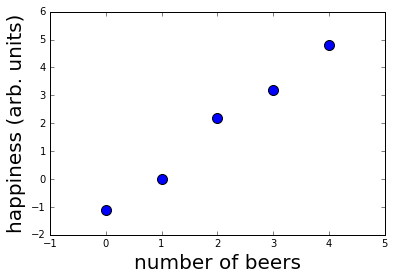

In [12]:
# dataset: univariate features with 5 samples and a corresponding continuous label
x_data = np.array([0, 1, 2, 3, 4])
y_data = np.array([-1.1, 0.0, 2.2, 3.2, 4.8])

# plot the relationship
plt.figure()
plt.scatter(x_data, y_data, s=100)
plt.xlabel('number of beers', fontsize=20)
plt.ylabel('happiness (arb. units)', fontsize=20)

#### reseting the default graph

Warning: Continually building variables and ops adds it to the default graph. If you don't keep track, the default graph can get bloated with unnecessary, disjointed sub-graphs. We can start from a fresh canvas by resetting the default graph:

In [13]:
tf.reset_default_graph()

Now let's build a linear model in tensorflow: $y = x W + b$. So, we'll need to create a placeholder for $x$ and trainable variables for $W$ and $b$.  

In [14]:
# placeholder to input the data
x = tf.placeholder(tf.float32, name="features")

# create variables for the model parameters
W = tf.Variable([.3], dtype=tf.float32, name="weight") 
b = tf.Variable([-.3], dtype=tf.float32, name="bias") 

# model
linear_model = W*x + b
# linear_model = tf.add(tf.multiply(W, x), b)

Let's see how our current linear model explains the data

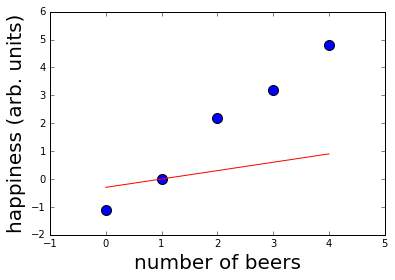

In [15]:
# get predictions
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    predictions = sess.run(linear_model, {x: x_data})
    
# plot the data and the predictions
plt.figure()
plt.scatter(x_data, y_data, s=100)
plt.xlabel('number of beers', fontsize=20)
plt.ylabel('happiness (arb. units)', fontsize=20)
plt.plot(x_data, predictions, 'r');


### Set up a loss function 

This should be no surprise that our model is crap!  But how crappy is it?  We need an objective function that tells us how good or bad our current model is from the provided data.  This function is also known as the cost function or the loss function. For a linear regression, the standard loss function is the sum of the squared errors between the model predictions and the observed data: 

$\mathcal{L} = \sum_i \left(f(x) - y \right)^2$


To evaluate the model, we need a $y$ placeholder to provide the target values.  Then, we can write out the full loss function.

In [16]:
# create placeholder for y
y = tf.placeholder(tf.float32) 

# calculate the squared errors
squared_deltas = tf.square(linear_model - y) 

# sum over the squared errors
loss = tf.reduce_sum(squared_deltas) 

### Optimizers

The loss function doesn't improve our predictions by itself.  It only tells us how far our current model is from the labels or targets provided by the data. Presumably, the optimal model parameters should take on values which would minimize the loss function.  In machine learning, one strategy to find this minimum is to employ gradient descent learning, which is to iteratively update the parameters of the model to navigate down the surface via gradients. In general, computing symbolic derivatives manually is tedious and error-prone. Fortunately, TensorFlow does auto differentiation for us, then update the values of w and b to minimize the loss. TensorFlow can automatically produce derivatives given only a description of the model using the function tf.gradients. For simplicity, optimizers typically do this for you. 

See Blog tutorial on autodiff: http://www.columbia.edu/~ahd2125/post/2015/12/5/


For example:

In [17]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01) 

# create op to calculate derivatives and update parameters
train_step = optimizer.minimize(loss) 

GradientDescentOptimizer means that our update rule is gradient descent. It modifies each variable according to the magnitude of the derivative of loss with respect to that variable, scaled by the learning rate. 

Optimizer is an op whose job is to minimize loss. To execute this op, we need to pass it into the list of fetches of tf.Session.run(). By default, the optimizer trains all the trainable variables its objective function depends on. If there are variables that you do not want to train, you can set the keyword trainable=False when you declare a variable.  

In this case, we see that optimizer depends on loss, and loss depends on inputs X,  Y, as well as two variables weights and bias. 

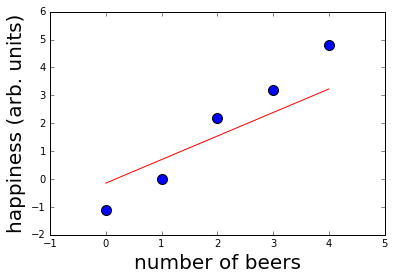

In [18]:
# start session
sess = tf.Session()

# initialize all variables
sess.run(tf.global_variables_initializer()) 

# execute optimizer 
sess.run(train_step, {x: x_data, y: y_data}) 

# get predictions
predictions = sess.run(linear_model, {x: x_data})

# plot the data and the predictions
plt.figure()
plt.scatter(x_data, y_data, s=100)
plt.xlabel('number of beers', fontsize=20)
plt.ylabel('happiness (arb. units)', fontsize=20)
plt.plot(x_data, predictions, 'r');

Notice that we ran the optimizer only once and the model predictions seem to be slightly better.  But, it's still not quite satisfactory.  So, let's run the optimizer many times to see if it helps.

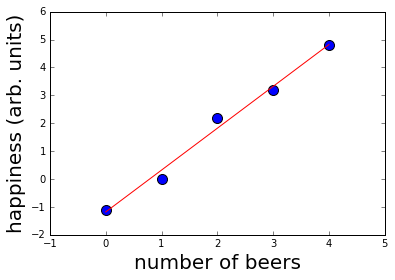

In [19]:
# let's train over many epochs
for i in range(1000):   

    # execute optimizer 
    sess.run(train_step, {x: x_data, y: y_data}) 

# get predictions
predictions = sess.run(linear_model, {x: x_data})

# plot the data and the predictions
plt.figure()
plt.scatter(x_data, y_data, s=100)
plt.xlabel('number of beers', fontsize=20)
plt.ylabel('happiness (arb. units)', fontsize=20)
plt.plot(x_data, predictions, 'r');

 Woohoo!  We did it! Congratulations, you just trained your first tensorflow model. 

# Where to go from here

go over tensorflow tutorials:
https://www.tensorflow.org/tutorials/

check out:
* tensorboard
* tf.estimator
* tf.data
* tf.summary

building better tensorflow models:
https://danijar.com/structuring-your-tensorflow-models/

blog on gradient descent optimizers:
http://ruder.io/optimizing-gradient-descent/
